In [1]:
from pybhpt.geo import KerrGeodesic
from pybhpt.radial import RadialTeukolsky
from pybhpt.teuk import TeukolskyMode
from pybhpt.hertz import HertzMode
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def teuk_static_check(l, geo):
    r = geo.semilatusrectum
    a = geo.blackholespin
    teukP=TeukolskyMode(2, l, 0, 0, 0, geo)
    teukM=TeukolskyMode(-2, l, 0, 0, 0, geo)
    teukP.solve(geo)
    teukM.solve(geo)
    lCH = teukP.eigenvalue + teukP.spinweight*(teukP.spinweight + 1)
    fM = lCH*(lCH - 2.)/(r**2 - 2.*r + a**2)**2
    dfM = -4.*lCH*(lCH - 2.)*(r - 1)/(r**2 - 2.*r + a**2)**3
    fP = lCH*(lCH - 2.)*(r**2 - 2.*r + a**2)**2
    dfP = 4.*lCH*(lCH - 2.)*(r - 1)*(r**2 - 2.*r + a**2)
    CMH = (lCH*(lCH - 2.))**2
    CMI = (lCH*(lCH - 2.))
    CPH = 1.
    CPI = (lCH*(lCH - 2.))
    RmIn = teukM.homogeneousradialsolution("In", 0)
    RPmIn = teukM.homogeneousradialderivative("In", 0)
    RmUp = teukM.homogeneousradialsolution("Up", 0)
    RPmUp = teukM.homogeneousradialderivative("Up", 0)
    RpIn = teukP.homogeneousradialsolution("In", 0)
    RPpIn = teukP.homogeneousradialderivative("In", 0)
    RpUp = teukP.homogeneousradialsolution("Up", 0)
    RPpUp = teukP.homogeneousradialderivative("Up", 0)
    # print(1. - CMH*RPmIn/(fP*RPpIn + dfP*RpIn), CMH*RPmIn, (fP*RPpIn + dfP*RpIn))
    # print(1. - CMI*RPmUp/(fP*RPpUp + dfP*RpUp), CMI*RPmUp, (fP*RPpUp + dfP*RpUp))
    # print(1. - CPH*RPpIn/(fM*RPmIn + dfM*RmIn), CPH*RPpIn, (fM*RPmIn + dfM*RmIn))
    # print(1. - CPI*RPpUp/(fM*RPmUp + dfM*RmUp), CPI*RPpUp, (fM*RPmUp + dfM*RmUp))
    print(CMH*RPmIn, (fP*RPpIn + dfP*RpIn), (fP*RPpIn , dfP*RpIn))
    print(CMI*RPmUp, (fP*RPpUp + dfP*RpUp), (fP*RPpUp , dfP*RpUp))
    print(CPH*RPpIn, (fM*RPmIn + dfM*RmIn), (fM*RPmIn , dfM*RmIn))
    print(CPI*RPpUp, (fM*RPmUp + dfM*RmUp), (fM*RPmUp , dfM*RmUp))

In [3]:
from scipy.special import sph_harm
from scipy.special import binom
from scipy.special import factorial

def fac(n):
    if n < 0:
        return 0
    return float(np.math.factorial(n))

def Yslm(s, l, m, th):
    if s == 0:
        return np.real(sph_harm(m, l, 0., th))
    elif s + m < 0:
        return (-1)**abs(s+m)*YslmBase(-s, l, -m, np.cos(th))
    else:
        return YslmBase(s, l, m, np.cos(th))

def YslmBase(s, l, m, z):
    rmax = l - s
    pref = (0.5)**(l)*(-1.)**m*np.sqrt(factorial(l+m)/factorial(l+s)*factorial(l-m)/factorial(l-s)*(2*l+1)/(4.*np.pi))*np.sqrt(1. - z)**(s + m)*np.sqrt(1. + z)**(s - m)
    
    yslm = 0.*pref
    for r in range(0, rmax + 1):
        yslm += binom(l - s, r)*binom(l + s, r + s - m)*(z - 1.)**(rmax - r)*(z + 1.)**(r)
    
    return pref*yslm

def clebsch(l1, l2, l3, m1, m2, m3):
    return (-1)**abs(l1 - l2 + m3)*np.sqrt(2*l3 + 1)*w3j(l1, l2, l3, m1, m2, -m3)

def w3j(l1, l2, l3, m1, m2, m3):
    if m1 + m2 + m3 != 0:
        return 0
    elif abs(l1 - l2) > l3:
        return 0
    elif l1 + l2 < l3:
        return 0
    
    if abs(m1) > l1:
        return 0
    elif abs(m2) > l2:
        return 0
    elif abs(m3) > l3:
        return 0
    
    sumTerm = w3j_tsum(l1, l2, l3, m1, m2, m3)
    if sumTerm == 0:
        return 0
    sumSign = np.sign(sumTerm)
    tempLog = 0.5*(np.log(fac(l1 + m1)) + np.log(fac(l2 + m2)) + np.log(fac(l3 + m3)))
    tempLog += 0.5*(np.log(fac(l1 - m1)) + np.log(fac(l2 - m2)) + np.log(fac(l3 - m3)))
    tempLog += np.log(triangle_coeff(l1, l2, l3))
    tempLog += np.log(abs(sumTerm))
    
    temp = sumSign*np.exp(tempLog)
    temp *= (-1)**abs(l1-l2-m3)
    
    return temp
    
def w3j_tsum(l1, l2, l3, m1, m2, m3):
    t_min_num = w3j_t_min(l1, l2, l3, m1, m2, m3)
    t_max_num = w3j_t_max(l1, l2, l3, m1, m2, m3)
    x = 0
    if t_max_num < t_min_num:
        t_max_num = t_min_num

    for t in range(t_min_num - 1, t_max_num + 2):
        term = (fac(t)*fac(l3 - l2 + m1 + t)*fac(l3 - l1 - m2 + t)
            *fac(l1 + l2 - l3 - t)*fac(l1 - t - m1)*fac(l2 - t + m2))
        if term > 0:
            x += (-1)**t/term
    
    return x

def w3j_t_min(l1, l2, l3, m1, m2, m3):
    temp = 0
    
    comp = l3 - l2 + m1
    if temp + comp < 0:
        temp = -comp
    comp = l3 - l1 - m2
    if temp + comp < 0:
        temp = -comp
        
    return temp

def w3j_t_max(l1, l2, l3, m1, m2, m3):
    temp = 1
    comp = l1 + l2 - l3
    if comp - temp > 0:
        temp = comp
    comp = l1 - m1
    if comp - temp > 0:
        temp = comp
    comp = l2 + m2
    if comp - temp > 0:
        temp = comp
        
    return temp

def triangle_coeff(l1, l2, l3):
    return np.sqrt(fac(l1 + l2 - l3)*fac(l3 + l1 - l2)*fac(l2 + l3 - l1)/fac(l1 + l2 + l3 + 1))

In [76]:
import pickle

class ModeGrid:
    def __init__(self, lmax, ptNum):
        self.maxl = lmax
        self.modeCount = 0
        self.lmodes = []
        self.mmodes = []
        for l in range(0, self.maxl + 1):
            for m in range(-l, l + 1):
                self.lmodes.append(l)
                self.mmodes.append(m)
        
        self.lmodes = np.array(self.lmodes)
        self.mmodes = np.array(self.mmodes)
        self.modes = np.zeros((self.lmodes.shape[0], ptNum), dtype=np.complex128)

    def pos(self, l, m):
        pos = np.where(np.logical_and(self.lmodes == l, self.mmodes == m))
        if len(pos) == 1:
            return pos[0]
        else:
            return pos

    def set(self, l, m, val):
        self.modes[self.pos(l, m)] = val

    def add(self, l, m, val):
        self.modes[self.pos(l, m)] += val
    
    def get(self, l, m):
        return self.modes[self.pos(l, m)]

    def __call__(self, l, m):
        return self.get(l, m)

class HertzCircularGrid:
    def __init__(self, orbit, gauge, rpts, lmax):
        self.maxl = lmax
        self.geo = orbit
        self.r0 = self.geo.semilatusrectum
        self.gauge = gauge
        self.inner = rpts[rpts <= self.r0]
        self.outer = rpts[rpts >= self.r0]
        self.pts = np.concatenate((self.inner, self.outer))
        self.psi = ModeGrid(lmax, self.pts.shape[0])
        self.dpsi = ModeGrid(lmax, self.pts.shape[0])
        self.ddpsi = ModeGrid(lmax, self.pts.shape[0])
        self.lmodes = np.arange(2, lmax + 1)
        self.mmodes = np.arange(-lmax, lmax + 1)
        self.filename = ".hertz_grid_a0_" + str(self.geo.blackholespin) + "_r0_" + str(self.r0) + "_gauge_" + str(self.gauge) + "_ptsNum_" + str(self.pts.shape[0]) + "_modeNum_" + str(self.lmodes.shape[0])

    def sanity_check(self, RInner, ROuter, hertz):
        r0UpIter = 0
        r0InIter = self.inner.shape[0] - 1
        Rup = ROuter.solution('Up', r0UpIter)
        Rin = RInner.solution('In', r0InIter)
        assert (np.abs(1. - Rin/hertz.homogeneousradialsolution('In', 0)) < 1.e-8), "Horizon-side Hertz field values of {} and {} do not match for mode {}".format(Rin, hertz.homogeneousradialsolution('In', 0), (RInner.spinweight, RInner.spheroidalmode, RInner.azimuthalmode, RInner.frequency))
        assert (np.abs(1. - Rup/hertz.homogeneousradialsolution('Up', 0)) < 1.e-8), "Infinity-side Hertz field values of {} and {} do not match for mode {}".format(Rup, hertz.homogeneousradialsolution('Up', 0),  (ROuter.spinweight, ROuter.spheroidalmode, ROuter.azimuthalmode, ROuter.frequency))

    def solve(self):
        if self.gauge in ["IRG", "ASAAB0", "SAAB0"]:
            s = -2
        else:
            s = 2
        for m in self.mmodes:
            jmin = np.max([2, abs(m)])
            lmin = jmin
            jmax = self.maxl + 4 + int(30*self.geo.blackholespin)
            for j in range(jmin, jmax + 1):
                teuk = TeukolskyMode(s, j, m, 0, 0, self.geo)
                teuk.solve(self.geo)
                hertz = HertzMode(teuk, self.gauge)
                hertz.solve()
                PsiUpJ = hertz.amplitude('Up')
                PsiInJ = hertz.amplitude('In')
                if self.outer.shape[0] > 0:
                    ROuter = RadialTeukolsky(s, j, m, teuk.blackholespin, teuk.frequency, self.outer)
                    ROuter.solve(bc='Up')
                    Rup = np.array([ROuter.radialsolution('Up', i) for i in range(self.outer.shape[0])])
                    dRup = np.array([ROuter.radialderivative('Up', i) for i in range(self.outer.shape[0])])
                    ddRup = np.array([ROuter.radialderivative2('Up', i) for i in range(self.outer.shape[0])])
                else:
                    Rup = np.array([])
                    dRup = np.array([])
                    ddRup = np.array([])
                    
                if self.inner.shape[0] > 0:  
                    RInner = RadialTeukolsky(s, j, m, teuk.blackholespin, teuk.frequency, self.inner)
                    RInner.solve(bc='In')
                    Rin = np.array([RInner.radialsolution('In', i) for i in range(self.inner.shape[0])])
                    dRin = np.array([RInner.radialderivative('In', i) for i in range(self.inner.shape[0])])
                    ddRin = np.array([RInner.radialderivative2('In', i) for i in range(self.inner.shape[0])])
                else:
                    Rin = np.array([])
                    dRin = np.array([])
                    ddRin = np.array([])

                for l in range(lmin, self.maxl + 1):
                    PsiIn = hertz.couplingcoefficient(l)*PsiInJ
                    PsiUp = hertz.couplingcoefficient(l)*PsiUpJ
                    Psi = np.concatenate((PsiIn*Rin, PsiUp*Rup)) 
                    dPsi = np.concatenate((PsiIn*dRin, PsiUp*dRup)) 
                    ddPsi = np.concatenate((PsiIn*ddRin, PsiUp*ddRup)) 
                    self.psi.add(l, m, Psi)
                    self.dpsi.add(l, m, dPsi)
                    self.ddpsi.add(l, m, ddPsi)

    def set(self, l, m, val0, val1, val2):
        self.psi.set(l, m, val0)
        self.dpsi.set(l, m, val1)
        self.ddpsi.set(l, m, val2)

    def save(self, fn = None):
        if fn is None:
            fn = self.filename + ".pkl"
        with open(fn, 'wb') as outp:
            pickle.dump([self.psi, self.dpsi, self.ddpsi], outp, pickle.HIGHEST_PROTOCOL)

    def load(self, fn = None):
        if fn is None:
            fn = self.filename + ".pkl"
        with open(fn, 'rb') as inp:
            tmp_array = pickle.load(inp)
            self.psi, self.dpsi, self.ddpsi = tmp_array
        
    def __call__(self, l, m, deriv=0):
        if deriv == 0:
            return self.psi(l, m)
        elif deriv == 1:
            return self.dpsi(l, m)
        elif deriv == 2:
            return self.ddpsi(l, m)
        else:
            return self.psi(l, m)

In [77]:
def HertzSchwCheck(l, m, hertz):
    teukPlus = TeukolskyMode(-2, l, m, 0, 0, hertz.geo)
    teukPlus.solve(hertz.geo)
    teukMinus = TeukolskyMode(-2, l, -m, 0, 0, hertz.geo)
    teukMinus.solve(hertz.geo)
    psiUpPlus = teukPlus.radialsolution('Up', 0)
    psiUpMinus = teukMinus.radialsolution('Up', 0)
    psiInPlus = teukPlus.radialsolution('In', 0)
    psiInMinus = teukMinus.radialsolution('In', 0)
    r0Iter = np.where(hertz.pts == hertz.r0)[0][0]
    hertzInCheck = hertz(l, m)[0, r0Iter]
    hertzUpCheck = hertz(l, m)[0, r0Iter + 1]
    hertzIn = 8*((-1)**m*((l - 1)*l*(l + 1)*(l + 2))*np.conj(psiInMinus) - 12j*(teukPlus.frequency)*psiInPlus)/(((l - 1)*l*(l + 1)*(l + 2))**2+(12*teukPlus.frequency)**2)
    hertzUp = 8*((-1)**m*((l - 1)*l*(l + 1)*(l + 2))*np.conj(psiUpMinus) - 12j*(teukPlus.frequency)*psiUpPlus)/(((l - 1)*l*(l + 1)*(l + 2))**2+(12*teukPlus.frequency)**2)
    hertzInError = np.abs(1 - hertzIn/hertzInCheck)
    hertzUpError = np.abs(1 - hertzUp/hertzUpCheck)
    return (hertzInError, hertzUpError, hertzIn, hertzInCheck, hertzUp, hertzUpCheck)

def HertzDerivSchwCheck(l, m, hertz):
    teukPlus = TeukolskyMode(-2, l, m, 0, 0, hertz.geo)
    teukPlus.solve(hertz.geo)
    teukMinus = TeukolskyMode(-2, l, -m, 0, 0, hertz.geo)
    teukMinus.solve(hertz.geo)
    psiUpPlus = teukPlus.radialderivative('Up', 0)
    psiUpMinus = teukMinus.radialderivative('Up', 0)
    psiInPlus = teukPlus.radialderivative('In', 0)
    psiInMinus = teukMinus.radialderivative('In', 0)
    r0Iter = np.where(hertz.pts == hertz.r0)[0][0]
    hertzInCheck = hertz(l, m, 1)[0, r0Iter]
    hertzUpCheck = hertz(l, m, 1)[0, r0Iter + 1]
    hertzIn = 8*((-1)**m*((l - 1)*l*(l + 1)*(l + 2))*np.conj(psiInMinus) - 12j*(teukPlus.frequency)*psiInPlus)/(((l - 1)*l*(l + 1)*(l + 2))**2+(12*teukPlus.frequency)**2)
    hertzUp = 8*((-1)**m*((l - 1)*l*(l + 1)*(l + 2))*np.conj(psiUpMinus) - 12j*(teukPlus.frequency)*psiUpPlus)/(((l - 1)*l*(l + 1)*(l + 2))**2+(12*teukPlus.frequency)**2)
    hertzInError = np.abs(1 - hertzIn/hertzInCheck)
    hertzUpError = np.abs(1 - hertzUp/hertzUpCheck)
    return (hertzInError, hertzUpError)

In [78]:
def muCoupling(l, n):
    if (l + n < 0) or (l - n + 1 < 0):
        return 0
    return np.sqrt((l - n + 1)*(l + n))

def C3Product(l1, m1, s1, l2, m2, s2, l3, m3, s3):
    return (-1.)**(m1 + s1)*np.sqrt((2.*l1 + 1)*(2.*l2 + 1)*(2.*l3 + 1)/(4.*np.pi))*w3j(l1, l2, l3, s1, -s2, -s3)*w3j(l1, l2, l3, -m1, m2, m3)

class MetricReconstructor:
    def __init__(self, hertz):
        self.maxl = hertz.maxl - 4
        self.maxl_hertz = hertz.maxl
        self.geo = hertz.geo
        self.blackholespin = self.geo.blackholespin
        self.r0 = self.geo.semilatusrectum
        self.gauge = hertz.gauge
        self.inner = hertz.inner
        self.outer = hertz.outer
        self.pts = hertz.pts
        self.h22 = ModeGrid(self.maxl, self.pts.shape[0])
        self.h23 = ModeGrid(self.maxl, self.pts.shape[0])
        self.h24 = ModeGrid(self.maxl, self.pts.shape[0])
        self.h33 = ModeGrid(self.maxl, self.pts.shape[0])
        self.h44 = ModeGrid(self.maxl, self.pts.shape[0])
        self.lmodes = np.unique(self.h22.lmodes)
        self.mmodes = np.unique(self.h22.mmodes)
        self.hertz_class = hertz

        self.frequency = self.geo.frequencies[-1]

    def hertz_mode(self, l, m, deriv=0):
        return self.hertz_class(l, m, deriv=deriv)[0]
    
    def hertz_dagger_mode(self, l, m, deriv=0):
        return (-1)**(l+m)*self.hertz_class(l, m, deriv=deriv)[0]
    
    def h22_coupling(self, l, m, l1, m1):
        Omega = self.frequency
        q = self.blackholespin
        r = self.pts
        hab = (4*q*self.hertz_mode(l1, m1, 0)*np.sqrt(np.pi)*(2*C3Product(l, m, 0, l1, m1, -2, 4, 0, 2)*np.sqrt(10)*m1**(2)*Omega**(2)*q**(3)+2*m1*Omega*C3Product(l, m, 0, l1, m1, -2, 3, 0, 2)*np.sqrt(210)*q**(2)*(1+m1*Omega*r*(1j))+m1*Omega*q*C3Product(l, m, 0, l1, m1, -2, 2, 0, 2)*np.sqrt(30)*(m1*Omega*(q**(2)-7*r**(2))+r*(14j))-4*m1*Omega*C3Product(l, m, 0, l1, m1, -1, 3, 0, 1)*np.sqrt(21)*q**(2)*muCoupling(l1, 2)-7*q*C3Product(l, m, 0, l1, m1, -1, 2, 0, 1)*np.sqrt(30)*muCoupling(l1, 2)*(1+m1*Omega*r*(2j))-7*C3Product(l, m, 0, l1, m1, -1, 1, 0, 1)*np.sqrt(6)*muCoupling(l1, 2)*(m1*Omega*(q**(2)-5*r**(2))+r*(5j))+7*q*C3Product(l, m, 0, 2, 0, 0, l1, m1, 0)*np.sqrt(5)*muCoupling(l1, 1)*muCoupling(l1, 2)+r*C3Product(l, m, 0, 1, 0, 0, l1, m1, 0)*np.sqrt(3)*(35j)*muCoupling(l1, 1)*muCoupling(l1, 2)))/(840)
        if l == l1 and l >= 2:
            hab += (35*self.hertz_mode(l, m, 0)*muCoupling(l, 1)*muCoupling(l, 2)*(q**(2)-3*r**(2)))/(840)
        return hab + np.conjugate(hab)

    # def h22_coupling(self, l, m, l1, m1):
    #     Omega = self.frequency
    #     q = self.blackholespin
    #     r = self.pts
    #     hab = (4*q*np.sqrt(np.pi)*(2*C3Product(l, m, 0, 4, 0, -2, l1, m1, 2)*self.hertz_dagger_mode(l1, m1, 0)*np.sqrt(10)*m1**(2)*Omega**(2)*q**(3)+2*C3Product(l, m, 0, l1, m1, -2, 4, 0, 2)*self.hertz_mode(l1, m1, 0)*np.sqrt(10)*m1**(2)*Omega**(2)*q**(3)+m1*Omega*C3Product(l, m, 0, 3, 0, -2, l1, m1, 2)*self.hertz_dagger_mode(l1, m1, 0)*np.sqrt(210)*q**(2)*(-2j)*(m1*Omega*r+(-1j))+2*m1*Omega*C3Product(l, m, 0, l1, m1, -2, 3, 0, 2)*self.hertz_mode(l1, m1, 0)*np.sqrt(210)*q**(2)*(1+m1*Omega*r*(1j))+m1*Omega*q*C3Product(l, m, 0, 2, 0, -2, l1, m1, 2)*self.hertz_dagger_mode(l1, m1, 0)*np.sqrt(30)*(m1*Omega*(q**(2)-7*r**(2))+r*(14j))+m1*Omega*q*C3Product(l, m, 0, l1, m1, -2, 2, 0, 2)*self.hertz_mode(l1, m1, 0)*np.sqrt(30)*(m1*Omega*(q**(2)-7*r**(2))+r*(14j))+4*m1*Omega*C3Product(l, m, 0, 3, 0, -1, l1, m1, 1)*self.hertz_dagger_mode(l1, m1, 0)*np.sqrt(21)*q**(2)*muCoupling(l1, 2)-4*m1*Omega*C3Product(l, m, 0, l1, m1, -1, 3, 0, 1)*self.hertz_mode(l1, m1, 0)*np.sqrt(21)*q**(2)*muCoupling(l1, 2)-7*q*C3Product(l, m, 0, 2, 0, -1, l1, m1, 1)*self.hertz_dagger_mode(l1, m1, 0)*np.sqrt(30)*muCoupling(l1, 2)*(1+m1*Omega*r*(2j))-7*q*C3Product(l, m, 0, l1, m1, -1, 2, 0, 1)*self.hertz_mode(l1, m1, 0)*np.sqrt(30)*muCoupling(l1, 2)*(1+m1*Omega*r*(2j))+7*C3Product(l, m, 0, 1, 0, -1, l1, m1, 1)*self.hertz_dagger_mode(l1, m1, 0)*np.sqrt(6)*muCoupling(l1, 2)*(m1*Omega*(q**(2)-5*r**(2))+r*(5j))-7*C3Product(l, m, 0, l1, m1, -1, 1, 0, 1)*self.hertz_mode(l1, m1, 0)*np.sqrt(6)*muCoupling(l1, 2)*(m1*Omega*(q**(2)-5*r**(2))+r*(5j))+7*q*C3Product(l, m, 0, 2, 0, 0, l1, m1, 0)*np.sqrt(5)*muCoupling(l1, 1)*muCoupling(l1, 2)*(self.hertz_dagger_mode(l1, m1, 0)+self.hertz_mode(l1, m1, 0))+r*C3Product(l, m, 0, 1, 0, 0, l1, m1, 0)*np.sqrt(3)*(35j)*muCoupling(l1, 1)*muCoupling(l1, 2)*(-1*self.hertz_dagger_mode(l1, m1, 0)+self.hertz_mode(l1, m1, 0))))/(840)
    #     if l == l1:
    #         hab += (35*muCoupling(l, 1)*muCoupling(l, 2)*(self.hertz_dagger_mode(l, m, 0)+self.hertz_mode(l, m, 0))*(q**(2)-3*r**(2)))/(840)
    #     return hab

    def h23_coupling(self, l, m, l1, m1):
        Omega = self.frequency
        q = self.blackholespin
        r = self.pts
        hab = (4*q*np.sqrt(np.pi)*(m1*Omega*C3Product(l, m, 1, 3, 0, -1, l1, m1, 2)*np.sqrt(42)*q**(2)*(-2j)*(m1*self.hertz_dagger_mode(l1, m1, 0)*(-2*q+Omega*q**(2)+Omega*r**(2))+self.hertz_dagger_mode(l1, m1, 1)*(1j)*(r*(-2+r)+q**(2)))+14*q*C3Product(l, m, 1, 2, 0, -1, l1, m1, 2)*np.sqrt(15)*(-1*self.hertz_dagger_mode(l1, m1, 1)*(r*(-2+r)+q**(2))+m1*self.hertz_dagger_mode(l1, m1, 0)*(1j)*(-1*q+Omega*q**(2)+Omega*r**(2)))+m1*Omega*C3Product(l, m, 1, 1, 0, -1, l1, m1, 2)*np.sqrt(3)*(-7j)*(self.hertz_dagger_mode(l1, m1, 0)*(m1*(q**(2)+5*r**(2))*(-2*q+Omega*q**(2)+Omega*r**(2))+r*(-10j)*(r*(-2+r)+q**(2)))+self.hertz_dagger_mode(l1, m1, 1)*(1j)*(2*r*q**(2)*(-1+3*r)+q**(4)+5*r**(3)*(-2+r)))+7*q*C3Product(l, m, 1, 2, 0, 0, l1, m1, 1)*np.sqrt(10)*muCoupling(l1, 2)*(self.hertz_dagger_mode(l1, m1, 1)*(r*(-2+r)+q**(2))+m1*self.hertz_dagger_mode(l1, m1, 0)*(-1j)*(-1*q+Omega*q**(2)+Omega*r**(2)))))/(840*(r*(-2+r)+q**(2)))
        if l == l1 and l >= 2:
            hab += (35*np.sqrt(2)*muCoupling(l, 2)*(-1*(q**(2)+3*r**(2))*(-1*self.hertz_dagger_mode(l, m, 1)*(r*(-2+r)+q**(2))+m*Omega*self.hertz_dagger_mode(l, m, 0)*(1j)*(q**(2)+r**(2)))+self.hertz_dagger_mode(l, m, 0)*(-6*r*q**(2)+6*r**(2)*(2-1*r)+m*q**(3)*(1j)+m*q*r**(2)*(3j))))/(840*(r*(-2+r)+q**(2)))
        return hab

    def h24_coupling(self, l, m, l1, m1):
        Omega = self.frequency
        q = self.blackholespin
        r = self.pts
        hab = (4*q*np.sqrt(np.pi)*(14*q*C3Product(l, m, -1, l1, m1, -2, 2, 0, 1)*np.sqrt(15)*(self.hertz_mode(l1, m1, 1)*(r*(-2+r)+q**(2))+m1*self.hertz_mode(l1, m1, 0)*(-1j)*(-1*q+Omega*q**(2)+Omega*r**(2)))+m1*Omega*C3Product(l, m, -1, l1, m1, -2, 3, 0, 1)*np.sqrt(42)*q**(2)*(-2j)*(m1*self.hertz_mode(l1, m1, 0)*(-1*q+Omega*q**(2)+Omega*r**(2))+self.hertz_mode(l1, m1, 1)*(1j)*(r*(-2+r)+q**(2)))+m1*Omega*C3Product(l, m, -1, l1, m1, -2, 1, 0, 1)*np.sqrt(3)*(-7j)*((q**(2)+5*r**(2))*(m1*Omega*self.hertz_mode(l1, m1, 0)*(q**(2)+r**(2))+self.hertz_mode(l1, m1, 1)*(1j)*(r*(-2+r)+q**(2)))-1*self.hertz_mode(l1, m1, 0)*(m1*(q**(3)+5*q*r**(2))+r*(10j)*(r*(-2+r)+q**(2))))+7*q*C3Product(l, m, -1, l1, m1, -1, 2, 0, 0)*np.sqrt(10)*muCoupling(l1, 2)*(-1*self.hertz_mode(l1, m1, 1)*(r*(-2+r)+q**(2))+m1*self.hertz_mode(l1, m1, 0)*(1j)*(-1*q+Omega*q**(2)+Omega*r**(2)))))/(840*(r*(-2+r)+q**(2)))
        if l == l1 and l >= 2:
            hab += (35*np.sqrt(2)*muCoupling(l, 2)*(self.hertz_mode(l, m, 0)*(6*r*q**(2)+6*r**(2)*(-2+r)+m*q*r**(2)*(-3j)+m*q**(3)*(-1j))+(q**(2)+3*r**(2))*(-1*self.hertz_mode(l, m, 1)*(r*(-2+r)+q**(2))+m*Omega*self.hertz_mode(l, m, 0)*(1j)*(q**(2)+r**(2)))))/(840*(r*(-2+r)+q**(2)))
        return hab

    def h33_coupling(self, l, m, l1, m1):
        Omega = self.frequency
        q = self.blackholespin
        r = self.pts
        hab = (q*C3Product(l, m, 2, 1, 0, 0, l1, m1, 2)*np.sqrt(3*np.pi)*(-2j)*(-1*Omega*q*self.hertz_dagger_mode(l1, m1, 0)*m1**(2)*(q**(2)+r**(2))-1*self.hertz_dagger_mode(l1, m1, 2)*(q**(2)+(-2+r)*r)**(2)+m1*self.hertz_dagger_mode(l1, m1, 1)*(2j)*(r*(-2+r)+q**(2))*(-1*q+Omega*q**(2)+Omega*r**(2))+m1*self.hertz_dagger_mode(l1, m1, 0)*(-2*m1*Omega*q**(3)+m1*Omega**(2)*q**(4)+Omega*r**(2)*(m1*Omega*r**(2)+(-2j))-2*q*(m1*Omega*r**(2)+r*(-1j)+(1j))+q**(2)*(m1+2*m1*Omega**(2)*r**(2)+Omega*(2j)))))/(12*(q**(2)+(-2+r)*r)**(2))
        if l == l1 and l >= 2:
            hab += ((3*Omega*q*r*self.hertz_dagger_mode(l, m, 0)*m**(2)*(q**(2)+r**(2))+3*r*self.hertz_dagger_mode(l, m, 2)*(q**(2)+(-2+r)*r)**(2)+self.hertz_dagger_mode(l, m, 1)*(6j)*(r*(-2+r)+q**(2))*(m*q*r+q**(2)*(-1*m*Omega*r+(1j))-1*r*(r*(m*Omega*r+(-1j))+(2j)))-3*self.hertz_dagger_mode(l, m, 0)*(r*m**(2)*q**(2)-2*Omega*r*m**(2)*q**(3)+r*m**(2)*Omega**(2)*q**(4)-2*Omega*q*m**(2)*r**(3)+2*m**(2)*Omega**(2)*q**(2)*r**(3)+m**(2)*Omega**(2)*r**(5)+m*q*r*(-6j)+m*Omega*q**(2)*r**(2)*(-4j)+m*Omega*q**(4)*(-2j)+m*Omega*r**(4)*(-2j)+m*q**(3)*(2j)+m*Omega*r**(3)*(2j)+m*q*r**(2)*(4j)+m*Omega*r*q**(2)*(6j))))/(12*(q**(2)+(-2+r)*r)**(2))
        return hab

    def h44_coupling(self, l, m, l1, m1):
        Omega = self.frequency
        q = self.blackholespin
        r = self.pts
        hab = (q*C3Product(l, m, -2, l1, m1, -2, 1, 0, 0)*np.sqrt(3*np.pi)*(2j)*((-1j)*(r*(-2+r)+q**(2))*(-2*m1*self.hertz_mode(l1, m1, 1)*(-1*q+Omega*q**(2)+Omega*r**(2))+self.hertz_mode(l1, m1, 2)*(-1j)*(r*(-2+r)+q**(2)))+m1*self.hertz_mode(l1, m1, 0)*(-2*m1*Omega*q**(3)+m1*Omega**(2)*q**(4)+Omega*r**(2)*(m1*Omega*r**(2)+(-2j))-2*q*(m1*Omega*r**(2)+r*(-1j)+(1j))+q**(2)*(m1+2*m1*Omega**(2)*r**(2)+Omega*(2j)))))/(12*(q**(2)+(-2+r)*r)**(2))
        if l == l1 and l >= 2:
            hab += ((3*(r*(-2+r)+q**(2))*(r*self.hertz_mode(l, m, 2)*(r*(-2+r)+q**(2))+self.hertz_mode(l, m, 1)*(2j)*(m*q*r+q**(2)*(-1*m*Omega*r+(1j))-1*r*(r*(m*Omega*r+(-1j))+(2j))))-3*self.hertz_mode(l, m, 0)*(r*m**(2)*q**(2)-2*Omega*r*m**(2)*q**(3)+r*m**(2)*Omega**(2)*q**(4)-2*Omega*q*m**(2)*r**(3)+2*m**(2)*Omega**(2)*q**(2)*r**(3)+m**(2)*Omega**(2)*r**(5)+m*q*r*(-6j)+m*Omega*q**(2)*r**(2)*(-4j)+m*Omega*q**(4)*(-2j)+m*Omega*r**(4)*(-2j)+m*q**(3)*(2j)+m*Omega*r**(3)*(2j)+m*q*r**(2)*(4j)+m*Omega*r*q**(2)*(6j))))/(12*(q**(2)+(-2+r)*r)**(2))
        return hab

    def reconstruct_22_with_coupling(self, l, m, l1):
        self.h22.add(l, m, self.h22_coupling(l, m, l1, m))

    def reconstruct_23_with_coupling(self, l, m, l1):
        self.h23.add(l, m, self.h23_coupling(l, m, l1, m))

    def reconstruct_24_with_coupling(self, l, m, l1):
        self.h24.add(l, m, self.h24_coupling(l, m, l1, m))

    def reconstruct_33_with_coupling(self, l, m, l1):
        self.h33.add(l, m, self.h33_coupling(l, m, l1, m))
    
    def reconstruct_44_with_coupling(self, l, m, l1):
        self.h44.add(l, m, self.h44_coupling(l, m, l1, m))

    def reconstruct_mode(self, modeFunc, l):
        for m in range(-l, l+1):
            lmin = np.max([abs(m), 2, l - 4])
            lmax = np.max([lmin, np.min([self.maxl_hertz, l + 4])])
            for l1 in range(lmin, lmax + 1):
                modeFunc(l, m, l1)

    def reconstruct_22(self):
        for l in range(2, self.maxl + 1):
            self.reconstruct_mode(self.reconstruct_22_with_coupling, l)
    
    def reconstruct_23(self):
        for l in range(2, self.maxl + 1):
            self.reconstruct_mode(self.reconstruct_23_with_coupling, l)

    def reconstruct_24(self):
        for l in range(2, self.maxl + 1):
            self.reconstruct_mode(self.reconstruct_24_with_coupling, l)

    def reconstruct_33(self):
        for l in range(2, self.maxl + 1):
            self.reconstruct_mode(self.reconstruct_33_with_coupling, l)

    def reconstruct_44(self):
        for l in range(2, self.maxl + 1):
            self.reconstruct_mode(self.reconstruct_44_with_coupling, l)

    def reconstruct(self):
        self.reconstruct_22()
        self.reconstruct_23()
        self.reconstruct_24()
        self.reconstruct_33()
        self.reconstruct_44()

In [79]:
def h22_coupling_check(q, Omega, r, hertz, l, m, l1, m1):
    hab = (4*q*hertz*np.sqrt(np.pi)*(2*C3Product(l, m, 0, l1, m1, -2, 4, 0, 2)*np.sqrt(10)*m1**(2)*Omega**(2)*q**(3)+2*m1*Omega*C3Product(l, m, 0, l1, m1, -2, 3, 0, 2)*np.sqrt(210)*q**(2)*(1+m1*Omega*r*(1j))+m1*Omega*q*C3Product(l, m, 0, l1, m1, -2, 2, 0, 2)*np.sqrt(30)*(m1*Omega*(q**(2)-7*r**(2))+r*(14j))-4*m1*Omega*C3Product(l, m, 0, l1, m1, -1, 3, 0, 1)*np.sqrt(21)*q**(2)*muCoupling(l1, 2)-7*q*C3Product(l, m, 0, l1, m1, -1, 2, 0, 1)*np.sqrt(30)*muCoupling(l1, 2)*(1+m1*Omega*r*(2j))-7*C3Product(l, m, 0, l1, m1, -1, 1, 0, 1)*np.sqrt(6)*muCoupling(l1, 2)*(m1*Omega*(q**(2)-5*r**(2))+r*(5j))+7*q*C3Product(l, m, 0, 2, 0, 0, l1, m1, 0)*np.sqrt(5)*muCoupling(l1, 1)*muCoupling(l1, 2)+r*C3Product(l, m, 0, 1, 0, 0, l1, m1, 0)*np.sqrt(3)*(35j)*muCoupling(l1, 1)*muCoupling(l1, 2)))/(840)
    if l == l1 and l >= 2:
        hab += (35*hertz*muCoupling(l, 1)*muCoupling(l, 2)*(q**(2)-3*r**(2)))/(840)
    return hab + np.conjugate(hab)

In [80]:
# geo = KerrGeodesic(0.5, 10., 0., 1.0, 2**2)
# hertz=HertzCircularGrid(geo, "IRG", np.linspace(4, 20, 33), 25)

In [81]:
geo = KerrGeodesic(0.5, 10., 0., 1.0, 2**2)
hertz=HertzCircularGrid(geo, "IRG", np.array([10.]), 25)
hertz.solve()

In [82]:
hab = MetricReconstructor(hertz)
hab.reconstruct()

In [103]:
def hertz_mode_test(l, m, gauge, geo):
    jmin = np.max([abs(m), 2])
    jmax = l + 20
    psi = np.zeros(2, dtype=np.complex128)
    dpsi = np.zeros(2, dtype=np.complex128)
    ddpsi = np.zeros(2, dtype=np.complex128)
    if gauge == "IRG":
        s = -2
    else:
        s = 2
    for j in range(jmin, jmax + 1):
        teuk = TeukolskyMode(s, j, m, 0, 0, geo)
        teuk.solve(geo)
        hertz = HertzMode(teuk, gauge)
        hertz.solve()
        PsiR = np.array([hertz.radialsolution('In', 0), hertz.radialsolution('Up', 0)])
        dPsiR = np.array([hertz.radialderivative('In', 0), hertz.radialderivative('Up', 0)])
        ddPsiR = np.array([hertz.radialderivative2('In', 0), hertz.radialderivative2('Up', 0)])
        psit, dpsit, ddpsit = hertz.couplingcoefficient(l)*np.array([PsiR, dPsiR, ddPsiR])
        # print(j, hertz.couplingcoefficient(l), teuk.frequency*teuk.blackholespin)
        psi += psit
        dpsi += dpsit
        ddpsi += ddpsit
    return psi, dpsi, ddpsi

In [84]:
def hertz_l_mode(l, hertz):
    gauge = hertz.gauge
    s = 2
    if gauge in ["IRG", "ASAAB0", "SAAB0"]:
        s = -2
    psil = np.zeros((hertz.pts.shape[0]), dtype=np.complex128)
    for m in range(-l, l + 1):
        psil += hertz(l, m)[0]*Yslm(s, l, m, 0.5*np.pi)
    return psil

In [85]:
def spin_zero_to_s_coupling(s, j, l, m):
    if s > 0:
        return (-1.)**(m + s)*np.sqrt(4**s*factorial(s)**2*(2*l + 1)*(2*j + 1)/factorial(2*s))*w3j(s, l, j, 0, m, -m)*w3j(s, l, j, s, -s, 0)
    else:
        return (-1.)**(m)*np.sqrt(4**(-s)*factorial(-s)**2*(2*l + 1)*(2*j + 1)/factorial(-2*s))*w3j(-s, l, j, 0, m, -m)*w3j(-s, l, j, s, -s, 0)


In [92]:
r0Iter = np.where(hab.pts==hab.r0)[0]
h22 = np.zeros((hab.maxl - 1, 2), dtype = np.complex128)
h24 = np.zeros((hab.maxl - 1, 2), dtype = np.complex128)
h44 = np.zeros((hab.maxl - 1, 2), dtype = np.complex128)
for l in range(0, hab.maxl + 1):
    for m in range(-l, l+1):
        for j in range(abs(m), hab.maxl - 1):
            Y0 = Yslm(0, j, m, 0.5*np.pi)
            h22[j] += spin_zero_to_s_coupling(0, j, l, m)*hab.h22(l, m)[0, r0Iter]*Y0
            h24[j] += spin_zero_to_s_coupling(-1, j, l, m)*hab.h24(l, m)[0, r0Iter]*Y0
            h44[j] += spin_zero_to_s_coupling(-2, j, l, m)*hab.h44(l, m)[0, r0Iter]*Y0

In [97]:
r0Iter = np.where(hab.pts==hab.r0)[0]
h22 = np.zeros((hab.maxl + 1, 2), dtype = np.complex128)
h24 = np.zeros((hab.maxl + 1, 2), dtype = np.complex128)
h44 = np.zeros((hab.maxl + 1, 2), dtype = np.complex128)
for l in range(0, hab.maxl + 1):
    for m in range(-l, l+1):
        h22[l] += hab.h22(l, m)[0, r0Iter]*Yslm(0, l, m, 0.5*np.pi)
        if l > 0:
            h24[l] += hab.h24(l, m)[0, r0Iter]*Yslm(-1, l, m, 0.5*np.pi)
        if l > 1:
            h44[l] += hab.h44(l, m)[0, r0Iter]*Yslm(-2, l, m, 0.5*np.pi)

In [98]:
from scipy.special import ellipk

def huu_reg(geo):
    L = geo.orbitalangularmomentum
    r0 = geo.semilatusrectum
    q = geo.blackholespin
    kappa = L**2 + q**2 + 2*q**2/r0
    k = kappa/(r0**2 + kappa)
    K = ellipk(k)
    return 2.*K/(np.pi*np.sqrt(kappa + r0**2))

def ut_circ(geo):
    v = 1./np.sqrt(geo.semilatusrectum)
    q = geo.blackholespin
    return (1. + q*v**3)/(np.sqrt(1 - 3*v**2 + 2.*q*v**3))

def u2_circ_norm(geo):
    Omega = geo.frequencies[-1]
    q = geo.blackholespin
    return (1. - q*Omega)

def u4_circ_norm(geo):
    Omega = geo.frequencies[-1]
    q = geo.blackholespin
    r0 = geo.semilatusrectum
    rhobar = -1./(r0)
    return 1.j*rhobar*(q - (r0**2 + q**2)*Omega)/np.sqrt(2.)

def htt_factors(geo):
    q = geo.blackholespin
    r0 = geo.semilatusrectum
    rhobar = -1./(r0)

    htt_22 = 0.5
    htt_24 = np.sqrt(2.)*1j*q*rhobar
    htt_44 = -0.5*q**2*rhobar**2

    return np.array([htt_22, htt_24, htt_44])

def htphi_factors(geo):
    q = geo.blackholespin
    r0 = geo.semilatusrectum
    rhobar = -1./(r0)

    htphi_22 = -q
    htphi_24 = -1.j*np.sqrt(2.)*(r0**2 + 2.*q**2)*rhobar
    htphi_44 = q*(r0**2 + q**2)*rhobar**2

    return 0.5*np.array([htphi_22, htphi_24, htphi_44])

def hphiphi_factors(geo):
    q = geo.blackholespin
    r0 = geo.semilatusrectum
    rhobar = -1./(r0)

    hphiphi_22 = 0.5*q**2
    hphiphi_24 = np.sqrt(2.)*1j*q*(r0**2 + q**2)*rhobar
    hphiphi_44 = -0.5*(r0**2 + q**2)**2*rhobar**2

    return np.array([hphiphi_22, hphiphi_24, hphiphi_44])

def hab_vec(geo, h22, h24, h44):
    q = geo.blackholespin
    r0 = geo.semilatusrectum
    rho = -1./(r0)
    rhobar = -1./(r0)
    return 4.*np.array([h22*rho**2*rhobar**2, h24*rho*rhobar**2, h44*rho])

def construct_htt(geo, hlist):
    hab_fac = htt_factors(geo)
    return 2.*(hab_fac[0]*hlist[0] + hab_fac[1]*hlist[1] + hab_fac[2]*hlist[2]).real

def construct_htphi(geo, hlist):
    hab_fac = htphi_factors(geo)
    return 2.*(hab_fac[0]*hlist[0] + hab_fac[1]*hlist[1] + hab_fac[2]*hlist[2]).real

def construct_hphiphi(geo, hlist):
    hab_fac = hphiphi_factors(geo)
    return 2.*(hab_fac[0]*hlist[0] + hab_fac[1]*hlist[1] + hab_fac[2]*hlist[2]).real

def completion(geo):
    dM = geo.orbitalenergy
    dJ = geo.orbitalangularmomentum
    r = geo.semilatusrectum
    q = geo.blackholespin
    htt = 2*dM/r
    htphi = -2*dJ/r
    hphiphi = 2.*q*((r + 2.)*dJ - (r + 1)*q*dM)/r
    Omega = geo.frequencies[-1]
    ut = ut_circ(geo)
    return 0.5*ut**2*(htt + 2.*Omega*htphi + Omega**2*hphiphi)

In [99]:
def huu_factors_check(geo):
    htt_fac = htt_factors(geo)
    htp_fac = htphi_factors(geo)
    hpp_fac = hphiphi_factors(geo)
    u2 = u2_circ_norm(geo)
    u4 = u4_circ_norm(geo)
    Omega = geo.frequencies[-1]
    comp1 = 1. - (u2*u2)/(2.*(htt_fac[0] + 2.*Omega*htp_fac[0] + Omega**2*hpp_fac[0]).real)
    comp2 = 1. - 4.*(u2*u4).real/(2.*(htt_fac[1] + 2.*Omega*htp_fac[1] + Omega**2*hpp_fac[1]).real)
    comp3 = 1. - 2.*(u4*u4).real/(2.*(htt_fac[2] + 2.*Omega*htp_fac[2] + Omega**2*hpp_fac[2]).real)
    return (comp1, comp2, comp3)

def huu_modes(geo, h22, h24, h44):
    hlist = hab_vec(geo, h22, h24, h44)
    htt = construct_htt(geo, hlist)
    htphi = construct_htphi(geo, hlist)
    hphiphi = construct_hphiphi(geo, hlist)
    Omega = hab.frequency
    ut = ut_circ(geo)
    huul = 0.5*ut**2*(htt + 2.*Omega*htphi + Omega**2*hphiphi)
    return huul

def huu_modes2(geo, h22, h24, h44):
    hlist = hab_vec(geo, h22, h24, h44)
    u2 = u2_circ_norm(geo)
    u4 = u4_circ_norm(geo)
    ut = ut_circ(geo)
    huul = 0.5*ut**2*(hlist[0]*u2*u2 + 4.*hlist[1]*u2*u4 + 2.*hlist[2]*u4*u4).real
    return huul

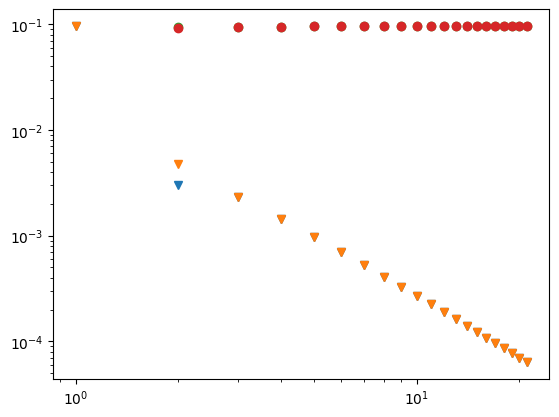

In [100]:
huul = huu_modes(geo, h22, h24, h44)
huul2 = huu_modes2(geo, h22, h24, h44)
H0reg=huu_reg(geo)
plt.plot(np.abs(huul[:]-H0reg), 'v')
plt.plot(np.abs(huul[:]), 'o')
plt.yscale('log')
plt.xscale('log')
plt.show()

In [101]:
from scipy.optimize import lsq_linear

def lbasis(lmax):
    return [1., ((lmax + 1)), ((lmax + 1)/(2*lmax + 1)/(2*lmax + 3)), ((lmax + 1)/(2*lmax + 1)/(2*lmax + 3)/(2*lmax - 1)/(2*lmax + 5))]

# def lbasis(lmax):
#     return [1., ((lmax + 1)), ((lmax + 1)/(2*lmax + 1)/(2*lmax + 3))]

# def lbasis(lmax):
#     return [1., ((lmax + 1)/(2*lmax + 1)/(2*lmax + 3)), ((lmax + 1)/(2*lmax + 1)/(2*lmax + 3)/(2*lmax - 1)/(2*lmax + 5))]

lminTest = 10
lmaxTest = hab.maxl - 2
ysum = np.array([np.sum(huul[:lmax + 1, 1]) for lmax in range(lminTest, lmaxTest + 1)])
xsum = np.array([lbasis(lmax) for lmax in range(lminTest, lmaxTest + 1)])

b = lsq_linear(xsum, ysum)
print(b)

 active_mask: array([0., 0., 0., 0.])
        cost: 5.761983793851552e-21
         fun: array([ 2.88911117e-11, -6.63702426e-11, -1.14530607e-12,  3.94295707e-11,
        3.53708174e-11,  6.55342447e-12, -2.33590924e-11, -3.59048347e-11,
       -1.87718729e-11,  3.53133078e-11])
     message: 'The unconstrained solution is optimal.'
         nit: 0
  optimality: 1.1035616864774056e-13
      status: 3
     success: True
           x: array([-0.20824323,  0.09692815,  0.11804602, -0.14893678])


In [91]:
print(b.x[1] - H0reg)
zval=(b.x[0] + completion(geo))*ut_circ(geo)
if geo.blackholespin == 0.5:
    mval=-0.1201650349
elif geo.blackholespin == 0.:
    mval=-0.12912227 
zval, mval, 1-zval/mval

8.538629803211961e-10


(-0.1241010417442441, -0.1201650349, -0.032755009371233657)